1/Γe = 2.12e-05 seconds
Time step δt = 2.12e-07 seconds
Step 0/70685
Step 1000/70685
Step 2000/70685
Step 3000/70685
Step 4000/70685
Step 5000/70685
Step 6000/70685
Step 7000/70685
Step 8000/70685
Step 9000/70685
Step 10000/70685
Step 11000/70685
Step 12000/70685
Step 13000/70685
Step 14000/70685
Step 15000/70685
Step 16000/70685
Step 17000/70685
Step 18000/70685
Step 19000/70685
Step 20000/70685
Step 21000/70685
Step 22000/70685
Step 23000/70685
Step 24000/70685
Step 25000/70685
Step 26000/70685
Step 27000/70685
Step 28000/70685
Step 29000/70685
Step 30000/70685
Step 31000/70685
Step 32000/70685
Step 33000/70685
Step 34000/70685
Step 35000/70685
Step 36000/70685
Step 37000/70685
Step 38000/70685
Step 39000/70685
Step 40000/70685
Step 41000/70685
Step 42000/70685
Step 43000/70685
Step 44000/70685
Step 45000/70685
Step 46000/70685
Step 47000/70685
Step 48000/70685
Step 49000/70685
Step 50000/70685
Step 51000/70685
Step 52000/70685
Step 53000/70685
Step 54000/70685
Step 55000/70685
Step 

NameError: name 'polarizations' is not defined

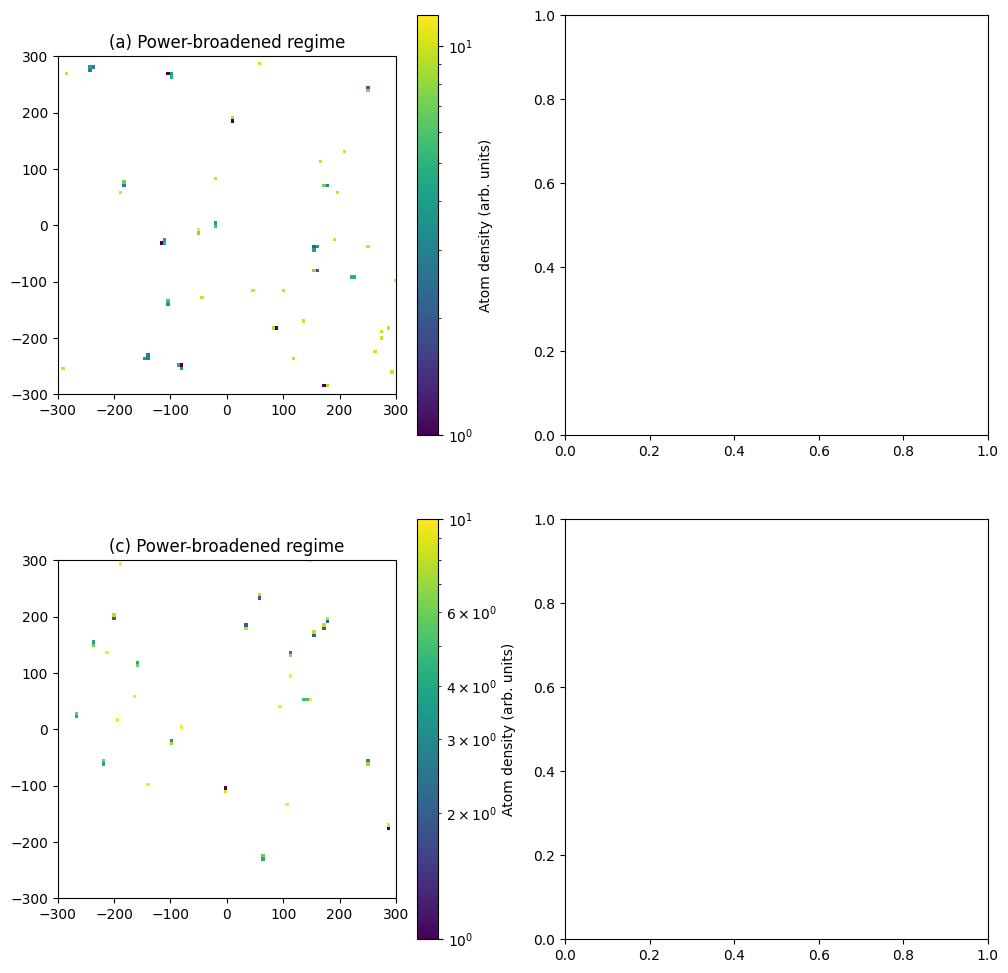

In [2]:
import numpy as np
from scipy.constants import h, hbar, mu_0, c, k, atomic_mass, g
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # Add this line

HIGH_SATURATION_THRESHOLD = 10

# At the top of your script, with other constants
gamma = 2 * np.pi * 7.5e3  # Natural linewidth (as before)
gamma_inverse = 1 / gamma  # This is 1/Γe

print(f"1/Γe = {gamma_inverse:.2e} seconds")

dt = gamma_inverse / 100
print(f"Time step δt = {dt:.2e} seconds")

# Constants
M = 88 * atomic_mass  # Mass of 88Sr
lambda_light = 689e-9  # Wavelength of 689 nm light
k_light = 2 * np.pi / lambda_light  # Wavenumber
gamma = 2 * np.pi * 7.5e3  # Natural linewidth
I_sat = 3 * np.pi * h * c * gamma / (2 * lambda_light**3)  # Saturation intensity
g_factor = 1.5  # Lande g-factor for 3P1 state
mu_B = 9.27400968e-24  # Bohr magneton

def initialize_atoms(num_atoms, initial_size, initial_temperature):
    """
    Initialize atoms with more realistic initial conditions.
    
    Args:
    num_atoms (int): Number of atoms to simulate
    initial_size (float): Characteristic size of the initial atom cloud (in meters)
    initial_temperature (float): Initial temperature of the atoms (in Kelvin)
    
    Returns:
    tuple: (positions, velocities)
    """
    # Initialize positions in a Gaussian distribution
    positions = np.random.normal(0, initial_size/2, (num_atoms, 3))
    
    # Initialize velocities from a Maxwell-Boltzmann distribution
    sigma_v = np.sqrt(k * initial_temperature / M)
    velocities = np.random.normal(0, sigma_v, (num_atoms, 3))
    
    return positions, velocities

def set_simulation_parameters(delta, S, gradient):
    return {
        'delta': delta,
        'S': S,
        'gradient': gradient,
        'gamma_prime': gamma * np.sqrt(1 + S)
    }

def setup_laser_beams():
    """
    Set up the laser beam configuration with proper polarizations and directions.
    
    Returns:
    tuple: (k_vectors, polarizations)
    """
    # Define the k-vectors for the six beams
    k_vectors = np.array([
        [1, 0, 0], [-1, 0, 0],  # x-axis beams
        [0, 1, 0], [0, -1, 0],  # y-axis beams
        [0, 0, 1], [0, 0, -1]   # z-axis beams
    ])
    
    # Define the polarization vectors for each beam
    polarizations = np.zeros((6, 3, 3), dtype=complex)
    
    # x-axis beams
    polarizations[0] = np.array([[0, 1, 1j], [1, 0, 0], [1j, 0, 0]]) / np.sqrt(2)
    polarizations[1] = np.array([[0, 1, -1j], [1, 0, 0], [-1j, 0, 0]]) / np.sqrt(2)
    
    # y-axis beams
    polarizations[2] = np.array([[1, 0, 1j], [0, 1, 0], [1j, 0, 0]]) / np.sqrt(2)
    polarizations[3] = np.array([[1, 0, -1j], [0, 1, 0], [-1j, 0, 0]]) / np.sqrt(2)
    
    # z-axis beams
    polarizations[4] = np.array([[1, 1j, 0], [1j, -1, 0], [0, 0, 1]]) / np.sqrt(2)
    polarizations[5] = np.array([[1, -1j, 0], [-1j, -1, 0], [0, 0, 1]]) / np.sqrt(2)
    
    return k_vectors, polarizations

def calculate_magnetic_field(positions, gradient):
    """
    Calculate the quadrupole magnetic field at given positions.
    
    Args:
    positions (array): Nx3 array of positions (x, y, z)
    gradient (float): Magnetic field gradient in T/m
    
    Returns:
    array: Nx3 array of magnetic field vectors (Bx, By, Bz)
    """
    return gradient * np.column_stack((
        positions[:, 0],  # Bx = gradient * x
        positions[:, 1],  # By = gradient * y
        -2 * positions[:, 2]  # Bz = -2 * gradient * z
    ))

def calculate_nMOT_distribution(x, z, delta, S, gradient):
    B = gradient * np.sqrt(x**2 + z**2)
    delta_omega_z = g_factor * mu_B * B / hbar
    detuning = delta - delta_omega_z
    gamma_prime = gamma * np.sqrt(1 + S)
    scattering_rate = 0.5 * gamma * S / (1 + S + 4 * (detuning / gamma_prime)**2)
    
    # Calculate the steady-state distribution
    T = 1e-6  # Assuming temperature ~1 µK
    distribution = np.exp(-M * g * z / (k * T))
    distribution *= scattering_rate
    
    return distribution

def calculate_cloud_properties(positions, velocities):
    """
    Calculate cloud size, position, and temperature.
    
    Args:
    positions (array): Nx3 array of atom positions
    velocities (array): Nx3 array of atom velocities
    
    Returns:
    dict: Dictionary containing cloud properties
    """
    # Calculate cloud position (center of mass)
    cloud_position = np.mean(positions, axis=0)
    
    # Calculate cloud size (standard deviation of positions)
    cloud_size = np.std(positions, axis=0)
    
    # Calculate temperature (from velocity distribution)
    velocity_variance = np.var(velocities, axis=0)
    temperature = M * velocity_variance / k
    
    return {
        'position': cloud_position,
        'size': cloud_size,
        'temperature': temperature
    }

def calculate_coupling_strength(B_local, k_vectors, polarizations):
    N = len(B_local)
    W = np.zeros((N, len(k_vectors), 3))
    
    B_norm = np.linalg.norm(B_local, axis=1)
    B_unit = B_local / B_norm[:, np.newaxis]
    
    CG = np.array([
        [1/np.sqrt(2), 1/np.sqrt(6), 1/np.sqrt(3)],  # σ+
        [0, -2/np.sqrt(6), 0],                       # π
        [-1/np.sqrt(2), 1/np.sqrt(6), -1/np.sqrt(3)] # σ-
    ])
    
    for i, (k, pol) in enumerate(zip(k_vectors, polarizations)):
        # Calculate the quantization axis
        e_q = B_unit
        
        # Project polarization vectors onto the quantization axis
        proj = np.abs(np.dot(pol, e_q.T))**2  # Shape: (3, N)
        
        # Calculate coupling strengths for each Zeeman sublevel
        for m in range(3):  # m_J = -1, 0, 1
            W[:, i, m] = np.sum(proj.T * CG[:, m]**2, axis=1)
    
    return W

def calculate_force(positions, velocities, params, k_vectors, zeeman_splitting, W):
    """
    Calculate the force on atoms.
    
    Args:
    positions (array): Nx3 array of atom positions
    velocities (array): Nx3 array of atom velocities
    params (dict): Parameters including delta, S, gradient
    k_vectors (array): Array of laser beam directions
    zeeman_splitting (array): Zeeman splitting for each atom
    W (array): Coupling strengths
    
    Returns:
    array: Nx3 array of forces on atoms
    """
    force = np.zeros_like(positions)
    
    for i, k in enumerate(k_vectors):
        doppler_shift = np.sum(velocities * k, axis=1)
        detuning = params['delta'] - doppler_shift[:, np.newaxis] - zeeman_splitting[:, np.newaxis] * np.array([-1, 0, 1])
        
        gamma_prime = gamma * np.sqrt(1 + params['S'])
        scattering_rate = 0.5 * gamma * params['S'] * W[:, i, :] / (1 + params['S'] + 4 * (detuning / gamma_prime)**2)
        
        force += hbar * k_light * np.sum(scattering_rate, axis=1)[:, np.newaxis] * k
    
    return force

def calculate_beam_force(detuning, S):
    """
    Calculate the force from a single beam.
    
    Args:
    detuning (float): Effective detuning
    S (float): Saturation parameter
    
    Returns:
    float: Force from this beam
    """
    gamma_prime = gamma * np.sqrt(1 + S)
    scattering_rate = 0.5 * gamma * S / (1 + S + 4 * (detuning / gamma_prime)**2)
    return hbar * k_light * scattering_rate

def calculate_laser_polarization(k_vectors):
    """
    Calculate the polarization vectors for each laser beam.
    
    Args:
    k_vectors (array): 6x3 array of laser beam directions
    
    Returns:
    array: 6x3x3 array of polarization vectors (ε+, ε0, ε-)
    """
    polarizations = np.zeros((len(k_vectors), 3, 3), dtype=complex)
    for i, k in enumerate(k_vectors):
        # Define the polarization vectors
        if np.allclose(k, [1, 0, 0]) or np.allclose(k, [-1, 0, 0]):  # x-axis beams
            epsilon_plus = np.array([0, 1, 1j]) / np.sqrt(2)
        elif np.allclose(k, [0, 1, 0]) or np.allclose(k, [0, -1, 0]):  # y-axis beams
            epsilon_plus = np.array([1, 0, 1j]) / np.sqrt(2)
        else:  # z-axis beams
            epsilon_plus = np.array([1, 1j, 0]) / np.sqrt(2)
        
        epsilon_minus = np.conj(epsilon_plus)
        epsilon_zero = np.cross(np.conj(epsilon_plus), epsilon_minus).real
        
        polarizations[i] = [epsilon_plus, epsilon_zero, epsilon_minus]
    
    return polarizations

def calculate_nMOT_distribution(x, z, delta, S, gradient):
    B = gradient * np.sqrt(x**2 + z**2)
    delta_omega_z = g_factor * mu_B * B / hbar
    detuning = delta - delta_omega_z
    gamma_prime = gamma * np.sqrt(1 + S)
    scattering_rate = 0.5 * gamma * S / (1 + S + 4 * (detuning / gamma_prime)**2)
    
    # Add gravity effect
    gravity_shift = M * g * z / (hbar * k_light)
    scattering_rate *= np.exp(-gravity_shift)
    
    return scattering_rate

def calculate_resonance_condition(x, z, delta, gradient):
    B = gradient * np.sqrt(x**2 + z**2)
    delta_omega_z = g_factor * mu_B * B / hbar
    return np.abs(delta_omega_z) == np.abs(delta)

def calculate_scattering_probability(delta, S, gamma, zeeman_splitting, velocities, k_vectors, W, dt):
    P = np.zeros((len(velocities), len(k_vectors), 3))
    
    for i, k in enumerate(k_vectors):
        doppler_shift = np.dot(velocities, k)
        detuning = delta - doppler_shift[:, np.newaxis] - zeeman_splitting[:, np.newaxis] * np.array([-1, 0, 1])
        gamma_prime = gamma * np.sqrt(1 + S)
        rho_ee = 0.5 * S / (1 + S + 4 * (detuning / gamma_prime)**2)
        P[:, i, :] = gamma * W[:, i, :] * rho_ee * dt
    
    return P

def calculate_zeeman_splitting(positions, gradient):
    """
    Calculate the Zeeman splitting for each atom based on its position in the magnetic field.
    
    Args:
    positions (array): Nx3 array of atom positions
    gradient (float): Magnetic field gradient in T/m
    
    Returns:
    array: N-element array of Zeeman splitting values
    """
    B_local = calculate_magnetic_field(positions, gradient)
    B_magnitude = np.linalg.norm(B_local, axis=1)
    delta_omega_z = g_factor * mu_B * B_magnitude / hbar
    return delta_omega_z

def determine_regime(S, delta, gamma):
    delta_normalized = abs(delta) / gamma
    if S <= 1 and delta_normalized > 10:
        return "Quantum"
    elif S > 1 and delta_normalized > 10:
        return "Power-broadened"
    else:
        return "Doppler"

def update_velocity_with_recoil(velocities, scattered_photons, k_vectors):
    recoil_velocity = hbar * k_light / M
    for i, k in enumerate(k_vectors):
        velocities += scattered_photons[:, i, :].sum(axis=1)[:, np.newaxis] * recoil_velocity * k

    # Add random emission recoil
    total_scattered = scattered_photons.sum(axis=(1, 2))
    emission_directions = np.random.randn(*velocities.shape)
    emission_directions /= np.linalg.norm(emission_directions, axis=1)[:, np.newaxis]
    velocities += total_scattered[:, np.newaxis] * recoil_velocity * emission_directions

    return velocities

def update_position_and_velocity(positions, velocities, dt):
    """
    Update positions and velocities considering gravity.
    """
    positions += velocities * dt + 0.5 * np.array([0, 0, -g]) * dt**2
    velocities += np.array([0, 0, -g]) * dt
    return positions, velocities

def run_simulation(num_atoms, total_time, initial_size, initial_temperature, delta, S, gradient):
    positions, velocities = initialize_atoms(num_atoms, initial_size, initial_temperature)
    params = set_simulation_parameters(delta, S, gradient)
    
    k_vectors, polarizations = setup_laser_beams()
    
    history = []
    
    num_steps = int(total_time / dt)
    for step in range(num_steps):
        if step % 1000 == 0:
            print(f"Step {step}/{num_steps}")
        
        B_local = calculate_magnetic_field(positions, gradient)
        zeeman_splitting = calculate_zeeman_splitting(positions, gradient)
        W = calculate_coupling_strength(B_local, k_vectors, polarizations)
        
        # Calculate forces
        forces = calculate_force(positions, velocities, params, k_vectors, zeeman_splitting, W)
        
        # Calculate scattering probabilities
        P = calculate_scattering_probability(params['delta'], params['S'], gamma, zeeman_splitting, velocities, k_vectors, W, dt)
        
        # Determine scattering events
        scattered_photons = np.random.random(P.shape) < P
        
        # Update velocities due to forces and scattering
        velocities += forces * dt / M  # Force contribution
        velocities = update_velocity_with_recoil(velocities, scattered_photons, k_vectors)
        
        # Update positions
        positions += velocities * dt + 0.5 * np.array([0, 0, -g]) * dt**2
        
        # Update velocities due to gravity
        velocities += np.array([0, 0, -g]) * dt
        
        if step % 10 == 0:  # Store history more frequently
            history.append((positions.copy(), velocities.copy()))
    
    regime = determine_regime(S, delta, gamma)
    return history, regime

def run_specific_simulation(delta, S, gradient, num_atoms=5000, total_time=15e-3):
    params = set_simulation_parameters(delta, S, gradient)
    initial_ellipsoid = np.array([100e-6, 100e-6, 100e-6])
    initial_temperature = 1e-6
    history = run_simulation(num_atoms, total_time, dt, initial_ellipsoid, initial_temperature, delta, S, gradient)
    return history, params

def generate_absorption_image(positions, bin_size):
    """
    Generate a simulated absorption image.
    """
    H, xedges, zedges = np.histogram2d(positions[:, 0], positions[:, 2], bins=bin_size)
    return H.T

def calculate_temperature(velocities):
    """
    Calculate the temperature from velocity distribution.
    """
    return M * np.var(velocities, axis=0) / k

def plot_absorption_and_force(ax_force, params, title_force, extra_S=None):
    # Force curve
    k_vectors = np.array([[0, 0, 1], [0, 0, -1]])  # Only vertical beams for simplicity
    z = np.linspace(-300e-6, 300e-6, 1000)
    positions = np.zeros((len(z), 3))
    positions[:, 2] = z
    velocities = np.zeros_like(positions)
    
    force = calculate_force(positions, velocities, params, k_vectors)
    ax_force.plot(force[:, 2] * 1e23, z * 1e6, 'r-', label=f'S = {params["S"]}')
    
    if extra_S is not None:
        extra_params = set_simulation_parameters(params['delta'], extra_S, params['gradient'])
        extra_force = calculate_force(positions, velocities, extra_params, k_vectors)
        ax_force.plot(extra_force[:, 2] * 1e23, z * 1e6, 'b-', label=f'S = {extra_S}')
    
    ax_force.set_xlabel('Force/10^-23 (N)')
    ax_force.set_ylabel('z (μm)')
    ax_force.legend()
    ax_force.set_title(title_force)
    ax_force.set_ylim(-300, 300)

def plot_cloud_evolution(properties1, properties2):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    time = np.arange(0, total_time, 100*dt)  # Assuming we saved properties every 100 steps
    
    # Plot cloud position
    axs[0].plot(time*1000, [p['position'][2]*1e6 for p in properties1], label='Case 1')
    axs[0].plot(time*1000, [p['position'][2]*1e6 for p in properties2], label='Case 2')
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Z position (µm)')
    axs[0].legend()
    
    # Plot cloud size
    axs[1].plot(time*1000, [p['size'][2]*1e6 for p in properties1], label='Case 1')
    axs[1].plot(time*1000, [p['size'][2]*1e6 for p in properties2], label='Case 2')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Cloud size (µm)')
    axs[1].legend()
    
    # Plot temperature
    axs[2].plot(time*1000, [p['temperature'][2]*1e6 for p in properties1], label='Case 1')
    axs[2].plot(time*1000, [p['temperature'][2]*1e6 for p in properties2], label='Case 2')
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Temperature (µK)')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()


def plot_figure1(history1, history2, params1, params2, regime1, regime2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Case 1: S = 250, Δ = -2π × 110 kHz
    positions1 = np.concatenate([h[0] for h in history1[-10:]])  # Use last 10 frames
    H1, xedges, zedges = np.histogram2d(positions1[:, 0], positions1[:, 2], 
                                        bins=100, range=[[-300e-6, 300e-6], [-300e-6, 300e-6]])
    im1 = axs[0, 0].imshow(H1.T, extent=[-300, 300, -300, 300], origin='lower', 
                           aspect='equal', cmap='viridis', norm=LogNorm())
    fig.colorbar(im1, ax=axs[0, 0], label='Atom density (arb. units)')
    axs[0, 0].set_title(f'(a) {regime1} regime')
    
    # Case 2: S = 20, Δ = -2π × 200 kHz
    positions2 = np.concatenate([h[0] for h in history2[-10:]])  # Use last 10 frames
    H2, xedges, zedges = np.histogram2d(positions2[:, 0], positions2[:, 2], 
                                        bins=100, range=[[-300e-6, 300e-6], [-300e-6, 300e-6]])
    im2 = axs[1, 0].imshow(H2.T, extent=[-300, 300, -300, 300], origin='lower', 
                           aspect='equal', cmap='viridis', norm=LogNorm())
    fig.colorbar(im2, ax=axs[1, 0], label='Atom density (arb. units)')
    axs[1, 0].set_title(f'(c) {regime2} regime')
    
    # Add resonance conditions
    for ax, params in zip([axs[0, 0], axs[1, 0]], [params1, params2]):
        x = np.linspace(-300e-6, 300e-6, 100)
        z = np.linspace(-300e-6, 300e-6, 100)
        X, Z = np.meshgrid(x, z)
        B = params['gradient'] * np.sqrt(X**2 + Z**2)
        delta_omega_z = g_factor * mu_B * B / hbar
        resonance = np.abs(delta_omega_z) == np.abs(params['delta'])
        ax.contour(X*1e6, Z*1e6, resonance, colors='r', linestyles='dashed', levels=[0.5])
    
    # Plot force curves
    plot_force_curve(axs[0, 1], params1, '(b)')
    plot_force_curve(axs[1, 1], params2, '(d)', extra_S=1)
    
    for ax in axs.flat:
        ax.set_xlabel('x (μm)')
        ax.set_ylabel('z (μm)')
    
    plt.tight_layout()
    plt.show()



def plot_force_curve(ax, params, title, extra_S=None):
    z = np.linspace(-300e-6, 300e-6, 1000)
    positions = np.zeros((len(z), 3))
    positions[:, 2] = z
    velocities = np.zeros_like(positions)
    k_vectors = np.array([[0, 0, 1], [0, 0, -1]])  # Only vertical beams for simplicity
    zeeman_splitting = calculate_zeeman_splitting(positions, params['gradient'])
    B_local = calculate_magnetic_field(positions, params['gradient'])
    W = calculate_coupling_strength(B_local, k_vectors, np.array([polarizations[4], polarizations[5]]))
    
    force = calculate_force(positions, velocities, params, k_vectors, zeeman_splitting, W)
    ax.plot(force[:, 2] * 1e23, z * 1e6, 'r-', label=f'S = {params["S"]}')
    
    if extra_S is not None:
        extra_params = params.copy()
        extra_params['S'] = extra_S
        extra_force = calculate_force(positions, velocities, extra_params, k_vectors, zeeman_splitting, W)
        ax.plot(extra_force[:, 2] * 1e23, z * 1e6, 'b-', label=f'S = {extra_S}')
    
    ax.set_xlabel('Force/10^-23 (N)')
    ax.set_ylabel('z (μm)')
    ax.legend()
    ax.set_title(title)
    ax.set_ylim(-300, 300)
    
def plot_scattering_rate(params, regime):
    z = np.linspace(-300e-6, 300e-6, 1000)
    positions = np.zeros((len(z), 3))
    positions[:, 2] = z
    velocities = np.zeros_like(positions)
    
    B_local = calculate_magnetic_field(positions, params['gradient'])
    k_vectors = np.array([[0, 0, 1], [0, 0, -1]])  # Only vertical beams for simplicity
    polarizations = calculate_laser_polarization(k_vectors)
    W = calculate_coupling_strength(B_local, k_vectors, polarizations)
    
    P = calculate_scattering_probability(params['delta'], params['S'], gamma, B_local, velocities, k_vectors, W, dt)
    scattering_rate = np.sum(P, axis=(1, 2)) / dt
    
    plt.figure(figsize=(10, 6))
    plt.plot(z*1e6, scattering_rate)
    plt.xlabel('z (μm)')
    plt.ylabel('Scattering rate (s^-1)')
    plt.title(f'Spatial dependence of scattering rate ({regime} regime)')
    plt.show()

# Main simulation parameters
num_atoms = 5000  # As mentioned in the paper
total_time = 15e-3  # 15 ms, as mentioned in the paper
initial_size = 5e-3  # 5 mm initial cloud size (adjust if the paper specifies differently)
initial_temperature = 1e-6  # 1 uK initial temperature (adjust if the paper specifies differently)
gradient = 8 * 1e-2  # 8 G/cm, as mentioned in the paper

"""
num_atoms = 50000  # Increased from 5000
total_time = 50e-3  # Increased from 15e-3
dt = 0.1 / gamma
initial_ellipsoid = np.array([100e-6, 100e-6, 100e-6])
initial_temperature = 1e-6
gradient = 8 * 1e-2  # 8 G/cm


# Run simulation
history = run_simulation(num_atoms, total_time, dt, initial_ellipsoid, initial_temperature, delta, S, gradient)

# Generate final absorption image
final_positions = history[-1][0]
absorption_image = generate_absorption_image(final_positions, bin_size=50)

# Calculate final temperature
final_velocities = history[-1][1]
temperature = calculate_temperature(final_velocities)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(absorption_image, extent=[-200e-6, 200e-6, -200e-6, 200e-6], origin='lower')
plt.colorbar(label='Atom density')
plt.title('Simulated Absorption Image')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

plt.subplot(122)
plt.hist(final_velocities[:, 2], bins=50, density=True)
plt.title('Velocity Distribution (z-axis)')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Probability density')

plt.tight_layout()
plt.show()

print(f"Final temperature: {temperature[2]*1e6:.2f} µK")
"""

# Run specific simulations for Figure 1
S1, delta1 = 250, -2 * np.pi * 110e3
history1, regime1 = run_simulation(num_atoms, total_time, initial_size, initial_temperature, delta1, S1, gradient)
params1 = set_simulation_parameters(delta1, S1, gradient)

S2, delta2 = 20, -2 * np.pi * 200e3
history2, regime2 = run_simulation(num_atoms, total_time, initial_size, initial_temperature, delta2, S2, gradient)
params2 = set_simulation_parameters(delta2, S2, gradient)

# Plot Figure 1
plot_figure1(history1, history2, params1, params2, regime1, regime2)

